In [16]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random
# from dataset_util import BirdDataset
from torch.utils.data import DataLoader, Dataset
from typing import List
from copy import deepcopy

In [17]:
train_df = pd.read_csv('/kaggle/input/aml2025-birds/train_images.csv')
train_df['image_path'] = '/kaggle/input/aml2025-birds/train_images' + train_df['image_path']
train_df["label_idx"] = train_df["label"] - 1
train_df.head()

,image_path,label,label_idx
0,/kaggle/input/aml2025-birds/train_images/train...,1,0
1,/kaggle/input/aml2025-birds/train_images/train...,1,0
2,/kaggle/input/aml2025-birds/train_images/train...,1,0
3,/kaggle/input/aml2025-birds/train_images/train...,1,0
4,/kaggle/input/aml2025-birds/train_images/train...,1,0


In [18]:
# class distribution
num_classes = train_df["label_idx"].nunique()
print("Number of images:", len(train_df))
print("Number of classes:", num_classes)
print("Rough check of balance:\n", train_df["label"].value_counts().unique())

Number of images: 3926
Number of classes: 200
Rough check of balance:
 [35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12
 11 10  9  8  7  6  5]


In [19]:
def transform_img(img, to_tensor=False, out_size: int=224):
    pad_size = abs(img.size[0] - img.size[1])
    if img.size[0] < img.size[1]:
        img = transforms.Pad((pad_size, 0))(img)
    else:
        img = transforms.Pad((0, pad_size))(img)
    img = transforms.Resize((out_size))(img)
    img = transforms.CenterCrop(out_size)(img)
    if to_tensor:
        img = transforms.ToTensor()(img)
    
    return img

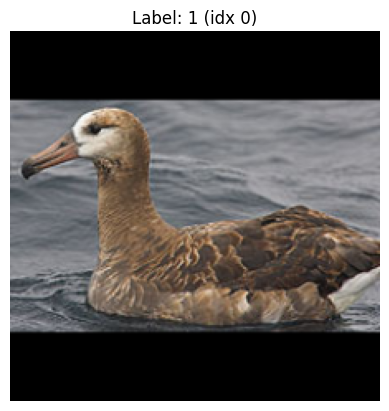

In [20]:
# see one bird (with transform)
row0 = train_df.iloc[31]
img = Image.open(row0["image_path"]).convert("RGB")
img = transform_img(img)
plt.imshow(img)
plt.title(f"Label: {row0['label']} (idx {row0['label_idx']})")
plt.axis("off")
plt.show()

In [21]:
class BirdDataset(Dataset):
    """
    Dataset tranformation.
    """
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
    
        img_path = row["image_path"]
        label = row["label_idx"]

        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image, to_tensor=True)
            MEAN = [0.485, 0.456, 0.406]
            STD = [0.229, 0.224, 0.225]
            image = transforms.Normalize(MEAN, STD)(image)

        return image, label
    

class BirdAttrDataset(Dataset):
    """
    Dataset that returns (image, class_label, attribute_vector)
    for multi-task learning.
    """
    def __init__(self, df, attributes, transform=None):
        self.df = df.reset_index(drop=True)
        if isinstance(attributes, torch.Tensor):
            self.attributes = attributes.float()
        else:
            self.attributes = torch.tensor(attributes, dtype=torch.float32)

        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_path = row["image_path"]
        label_idx = int(row["label_idx"])

        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        # attribute vector for this class
        attr_vec = self.attributes[label_idx]

        return image, label_idx, attr_vec


class TestSet():
    def __init__(self, transform):
        self.test_df = pd.read_csv('/kaggle/input/aml2025-birds/test_images_path.csv')
        self.test_df['image_path'] = '/kaggle/input/aml2025-birds/test_images' + self.test_df['image_path']
        self.transform = transform

    def predict(self, img_path, model, device):
        model.eval()

        img = Image.open(img_path).convert('RGB')
        img = self.transform(img, to_tensor=True)
        MEAN = [0.485, 0.456, 0.406]
        STD = [0.229, 0.224, 0.225]
        img = transforms.Normalize(MEAN, STD)(img)
        img = img.unsqueeze(0)
        img.to(device)

        with torch.no_grad():
            logits = model(img)
            pred = logits.argmax(dim=1).item()
        
        return pred + 1

    def predict_all(self, prediction_model):
        self.test_df['label'] = self.test_df['image_path'].apply(self.predict, model=prediction_model)

    def get_df(self):
        return self.test_df
    
    def convert_to_submission(self):
        submission = self.test_df.copy(deep=True)
        submission.drop(columns=['image_path'], inplace=True)
        now_str = datetime.now().strftime("%d-%m-%Y_at_%H_%M") 
        submission.to_csv(f'predictions/predictions_{now_str}.csv', index=False)


### Genome

In [22]:
class GeneBlock:
    # One block configuration
    def __init__(self):
        self.type = nn.Conv2d
        self.filters = np.random.choice([32,64,128,256])
        self.kernel = np.random.choice([3, 1], p=[0.8, 0.2]) #), (5,5)], p=[0.75, 0.2, 0.05])
        if self.kernel == 1: # dimensionality reduction
            self.stride = 1
            self.padding = 0
        else:
            self.stride, self.padding = random.choices([(1,1), (2,0)], weights=[0.7,0.3])[0] # standard feature extraction, downsampling
        self.activation = nn.ReLU()
        self.apply_pooling = np.random.choice([True, False])
        if self.apply_pooling or self.filters in [128,256]:
            self.pooling = np.random.choice([nn.AvgPool2d(2), nn.MaxPool2d(2)])
        else:
            self.pooling = nn.Identity()
        self.apply_dropout = np.random.choice([True, False])
        if self.apply_dropout:
            self.dropout = nn.Dropout(np.random.choice([0.01, 0.05, 0.1], p=[0.7, 0.25, 0.05]))
        else:
            self.dropout = nn.Identity()
    
    def create_block(self, channels_in: int):
        block = nn.Sequential(
            self.type(channels_in, self.filters, self.kernel, self.stride, self.padding),
            self.activation,
            self.pooling,
            self.dropout
        )
        #if self.apply_dropout:
            #block = nn.Sequential(
                #*block,
                #self.dropout
            #)
        return block


In [23]:
class Genome:
    # Full network
    def __init__(self):
        #self.current_H_W = 224
        #self.blocks = []
        #for _ in range(np.random.randint(2,8)):
            #block= GeneBlock(self.current_H_W)
        self.blocks = [GeneBlock() for _ in range(np.random.randint(2,5))]
        self.model = []
        self.optimizer = np.random.choice([torch.optim.Adam, torch.optim.AdamW, torch.optim.SGD])
        self.learning_rate = np.random.choice([1e-2, 1e-3])
        self.fitness = 0.0
        self.is_valid = True
    
    def calculate_output_dim(size_in, kernel_size, padding, stride):
        return np.floor((size_in + 2 * padding - kernel_size) / stride) + 1
        

    def build_model(self):
        current_channels = 3 # RGB

        # First block
        self.model = self.blocks[0].create_block(current_channels)
        current_channels = self.blocks[0].filters

        # Remaining blocks
        for block in self.blocks[1:]:
            self.model = nn.Sequential(
                *self.model,
                block.create_block(current_channels)
            )
            current_channels = block.filters

        # Final block
        self.model = nn.Sequential(
            *self.model,
            nn.Conv2d(current_channels, current_channels * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        current_channels = current_channels * 2

        # Fully connected layer
        # fully_connected_featured_dim = np.random.choice([128,256])
        self.model = nn.Sequential(
            *self.model,
            nn.Flatten(),
            #nn.Linear(current_channels, fully_connected_featured_dim),
            nn.Linear(current_channels, 200),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        x = self.model(x)
        return x

In [24]:
test = Genome()
test.build_model()
test.model

Sequential(
  (0): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Identity()
  (4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Identity()
  )
  (5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): AdaptiveAvgPool2d(output_size=(1, 1))
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=512, out_features=200, bias=True)
  (10): ReLU()
)

### Evolutionary Algorithm

In [25]:
class BirdEA:
    def __init__(self, pop_size: int, n_gens: int, p_crossover: float, m_rate: float,
                 train_loader: DataLoader, val_loader: DataLoader, device, epochs_list: List[int]):
        self.population_size = pop_size
        self.n_gens = n_gens
        self.p_crossover = p_crossover
        self.m_rate = m_rate
        self.x_best = []
        self.f_best = []
        self.epochs_list = epochs_list
        self.n_epochs = self.epochs_list[0]
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.criterion = nn.CrossEntropyLoss()

        self.x: List[Genome] = []
        self.f: List[float] = []

    def initialize(self):
        x = []
        for _ in range(self.population_size):
            x.append(Genome())
        
        return x

    def select_parents(self):
        individuals = list(zip(self.x, self.f))

        # Sort based on fitness
        individuals.sort(reverse=True, key=lambda x: x[1])

        # Select best half
        selected_individuals = individuals[:len(individuals)//2]

        x_parents, f_parents = list(zip(*selected_individuals))

        return list(x_parents), list(f_parents)


    def crossover(self, x_parents):
        offspring = []
        # Generate parent pools for easy matching
        # Random half split

        x_parents_list = list(x_parents) 
        np.random.shuffle(x_parents_list) 

        parent_pool1 = x_parents_list[:len(x_parents_list)//2]
        parent_pool2 = x_parents_list[len(x_parents_list)//2:]
        
        # Match parents with the same indices
        for i in range(len(parent_pool1)):
            # Initialize children
            child1 = deepcopy(parent_pool1[i])
            child2 = deepcopy(parent_pool2[i])
            crossover_index = 0
            
            n_blocks = (len(child1.blocks) + len(child2.blocks)) // 2

            for _ in range(n_blocks):
                crossover_index += np.random.binomial(1, self.p_crossover)
            
            # Crossover blocks between parents at the crossover index
            child1.blocks[crossover_index:] = parent_pool2[i].blocks[crossover_index:]
            child2.blocks[crossover_index:] = parent_pool1[i].blocks[crossover_index:]
            
            # Add children to offspring
            offspring.append(child1)
            offspring.append(child2)

        return offspring

    def mutate(self, offspring):
        mutated_x = []

        # Possible mutations:
        # - Change block (maybe just parts of block later)
        # - Change optimizer
        # - Change learning rate
        for individual in offspring:
            mutated_individual = deepcopy(individual)
            
            if np.random.binomial(1, self.m_rate):
                individual.optimizer = np.random.choice([torch.optim.Adam, torch.optim.AdamW, torch.optim.SGD])
            if np.random.binomial(1, self.m_rate):
                individual.learning_rate = np.random.choice([1e-2, 1e-3])
            for block_idx in range(len(individual.blocks)):
                if np.random.binomial(1, self.m_rate):
                    individual.blocks[block_idx] = GeneBlock()
            
            mutated_x.append(mutated_individual)

        # Return individuals and mutated form
        return offspring + mutated_x


    def train_and_evaluate(self, generation) -> List[float]:
        fitness = []

        for individual in generation:
            try:
                lr = individual.learning_rate
                individual.build_model()
                model = individual.model.to(self.device)
                #print(model)
                optim = individual.optimizer(model.parameters(), lr=lr)
                #print(optim)
                best_val_loss = np.inf
                
                # Training
                for epoch in range(self.n_epochs):
                    model.train()
                    running_loss = 0.0
                    running_total = 0

                    for images, labels in self.train_loader:
                        images = images.to(self.device)
                        labels = labels.to(self.device)

                        optim.zero_grad()

                        # Forward pass
                        logits = model(images)
                        loss = self.criterion(logits, labels)

                        # Backward pass
                        loss.backward()
                        optim.step()

                        running_loss += loss.item() * images.size(0)
                        running_total += labels.size(0)
                    
                    # epoch_train_loss = running_loss / running_total

                    # Validation (fitness)
                    model.eval()
                    val_running_loss = 0.0
                    val_running_total = 0

                    with torch.no_grad():
                        for images, labels, in self.val_loader:
                            images = images.to(self.device)
                            labels = labels.to(self.device)

                            logits = model(images)
                            loss = self.criterion(logits, labels)

                            val_running_loss += loss.item() * images.size(0)
                            val_running_total += labels.size(0)
                        
                        val_loss = val_running_loss / val_running_total
                        if val_loss < best_val_loss:
                            best_val_loss = val_loss
                
                fitness.append(best_val_loss)
                
            except Exception as e:
                print(f"Error Type: {type(e).__name__}")
                print(f"Error Message: {e}")
                fitness.append(np.inf)
                
        return fitness
    
    def next_gen(self, x_parents, f_parents, mutated_offspring, f_mutated_offspring):
        # Survivor selection
        total_x = x_parents + mutated_offspring
        total_f = list(f_parents) + list(f_mutated_offspring)

        individuals = list(zip(total_x, total_f))
        
        # Sort individuals based on fitness
        individuals.sort(reverse=True, key=lambda x: x[1])

        # Select the best 2/3
        selected_individuals = individuals[:len(individuals * 2)//3]

        self.x, self.f = list(zip(*selected_individuals))


    def update_best(self, init=False):
        idx = np.argmax(self.f)
        x_best_i = self.x[idx]
        f_best_i = self.f[idx]

        if init or f_best_i < self.f_best[-1]:
            self.x_best.append(x_best_i)
            self.f_best.append(f_best_i)
        else: # previous generation best individual still the best
            self.x_best.append(self.x_best[-1])
            self.f_best.append(self.f_best[-1])

        print(f'\tCurrent best fitness (loss): {self.f_best[-1]}')
        print(f'\tCurrent best model: {self.x_best[-1]}')

    def run_ea(self):
        self.x: List[Genome] = self.initialize()
        print('Training and evaluating generation 1')
        self.f: List[float] = self.train_and_evaluate(self.x)
        self.update_best(init=True)
        
        for gen in range(2, self.n_gens+1): # start at 2 to account for initial population
            print(f'Evolving, training, and evaluating generation {gen}')
            if (gen / self.n_gens) >= (2 / 3):
                self.n_epochs = self.epochs_list[-1]
            elif (gen / self.n_gens) >= (1 / 3):
                self.n_epochs = self.epochs_list[1]

            # Get parents for breeding
            x_parents, f_parents = self.select_parents()
            # Generate offspring using crossover
            offspring = self.crossover(x_parents)
            # Mutate offspring
            mutated_offspring = self.mutate(offspring)
            # Get loss (fitness)
            f_mutated_offspring = self.train_and_evaluate(mutated_offspring)
            # Go to next generation by selecting survivors
            self.next_gen(x_parents, f_parents, mutated_offspring, f_mutated_offspring)
            # Update best individuals list
            self.update_best()

        print(f'Best individual with fitness (loss) of {self.f_best[-1]}')
        print(self.x_best[-1])

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [27]:
# train test split
train_df_split, val_df_split = train_test_split(train_df, test_size=0.2, stratify=train_df["label_idx"], random_state=42)

batch_size = 16 # 32

train_dataset = BirdDataset(train_df_split, transform=transform_img)
val_dataset = BirdDataset(val_df_split, transform=transform_img)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [28]:
# n_gens=20, epochs_list=[7,15,25]
bird_ea_test = BirdEA(pop_size=10, n_gens=5, p_crossover=0.5, m_rate=0.1, train_loader=train_loader, val_loader=val_loader, device=device, epochs_list=[3,6,10])

In [29]:
bird_ea_test.run_ea()

Training and evaluating generation 1
	Current best fitness (loss): 5.2977310209783885
	Current best model: <__main__.Genome object at 0x79f75c5ded10>
Evolving, training, and evaluating generation 2
	Current best fitness (loss): 5.2977310209783885
	Current best model: <__main__.Genome object at 0x79f75c5ded10>
Evolving, training, and evaluating generation 3
	Current best fitness (loss): 5.2977310209783885
	Current best model: <__main__.Genome object at 0x79f75c5ded10>
Evolving, training, and evaluating generation 4
	Current best fitness (loss): 5.2977310209783885
	Current best model: <__main__.Genome object at 0x79f75c5ded10>
Evolving, training, and evaluating generation 5
	Current best fitness (loss): 5.2977310209783885
	Current best model: <__main__.Genome object at 0x79f75c5ded10>
Evolving, training, and evaluating generation 6
	Current best fitness (loss): 5.2977310209783885
	Current best model: <__main__.Genome object at 0x79f75c5ded10>
Evolving, training, and evaluating generation

KeyboardInterrupt: 

In [30]:
bird_ea_test.x_best[-1].model

Sequential(
  (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.01, inplace=False)
  (4): Sequential(
    (0): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Identity()
  )
  (5): Sequential(
    (0): Conv2d(32, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Identity()
  )
  (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): AdaptiveAvgPool2d(output_size=(1, 1))
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=512, out_features=200, bias=True)
  (11): ReLU()
)